In [1]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib_venn import venn2, venn3
import pybedtools
import numpy as np
from IPython.core.display import HTML
import pandas as pd

from gscripts import GO
from gscripts.rnaseq import splicing_map
from gscripts.general import dataviz
from gscripts.general import region_helpers

img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/splicing_maps"
heatmap_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/heatmaps"

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [4]:
# master_processing_table = pd.read_table("/home/elvannostrand/data/ENCODE/project_stuff/ENCODE_MASTER_ID_LIST_20160301_AllDatasets.txt", 
#                                         sep="\t",
#                                         skiprows=1,
#                                         names=["UID", "RBP_gID", "CellLine", "RBP_ENSG", "Antibody", "Lot", "CLIP_ENCODEAccID", "CLIP_Rep1ENC", "CLIP_Rep2ENC", "CLIP_InputENC", "RNASEQ_ENCODEAccID",  "Duplicate_RNASEQ_ENCODEAccID", "RNASEQ_ControlENC", "RNASEQ_KDRep1Bam", "RNASEQ_KDRep2Bam", "RNASEQ_ControlRep1Bam", "RNASEQ_ControlRep2Bam", "bar"]
# )

master_processing_table = pd.read_table("/home/gpratt/Dropbox/encode_integration/20160408_ENCODE_MASTER_ID_LIST_AllDatasets.csv", index_col=0 )
rna_only_data = master_processing_table[master_processing_table.selection_method != "polyadenylated mRNA"].RNASEQ_ENCODEAccID.dropna()

In [5]:
all_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/ipython_data/merged_cryptic_events.csv", 
            index_col=[0,1,2,3,4,5])

all_events.rename(columns={"rbp.1": "rbp", "cell_type.1": "cell_type", "both.1": "both"}, inplace=True)
id_to_name = dict(izip(all_events.index.get_level_values(level="condition"), all_events.index.get_level_values(level="both")))
all_events = all_events.drop("MN", level="cell_type")
all_events['condition'] = all_events.index.get_level_values("condition").map(lambda x: x.split("_vs_")[0])
all_events = all_events[~all_events['condition'].isin(rna_only_data)]

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13,14,16,17,20,21,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
def get_significant_events(events):
    sig_events = events[events.FDR < .05]
    sig_events = sig_events[np.abs(sig_events.IncLevelDifference) > .1]
    sig_events = pd.concat({"excluded": sig_events[sig_events.IncLevelDifference < 0],
                            "included": sig_events[sig_events.IncLevelDifference > 0],}, 
                           names=["direction", "event_type", "condition", "both", "rbp", "cell_type", "event_id"])
    sig_events = sig_events.swaplevel(0,1)
    return sig_events

all_events['is_cryptic'] = all_events.is_cryptic.fillna(True)
all_annotated_events = all_events[~all_events.is_cryptic]

all_sig_events = get_significant_events(all_annotated_events)
background_events = all_annotated_events[all_annotated_events.FDR > .05]

all_sig_stress_events = all_sig_events[all_sig_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]
background_stress_events = background_events[background_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]

In [19]:
names = ['cryptic_chrom', 'cryptic_start', "cryptic_stop", 'cryptic_name',
         'rbp_chrom', 'rbp_start', 'rbp_stop', 'rbp_name', 'rbp_score', 'rbp_strand', "rbp_foo", 'rbp_bar', 'rbp_color', 'foo', 'bar', 'baz', 'buz']

master_peaks = {"K562":  pybedtools.BedTool("/home/gpratt/Dropbox/cryptic_splicing/data/clip/encode_v12_filelist.allencode_20160226.txt.K562_allpeaks_ENCODEv12.colored.bed").sort().saveas(),
                "HEPG2":  pybedtools.BedTool("/home/gpratt/Dropbox/cryptic_splicing/data/clip/encode_v12_filelist.allencode_20160226.txt.HepG2_allpeaks_ENCODEv12.colored.bed").sort().saveas()}

In [20]:
#Do all the combinations, but it takes forever, so I leave this commented out

# sig_rMATS = se[se.FDR < .05].copy()

# sig_rMATS['upstreamES'] = sig_rMATS.upstreamES.astype(int)
# sig_rMATS['upstreamEE'] = sig_rMATS.upstreamEE.astype(int)
# sig_rMATS['exonStart_0base'] = sig_rMATS.exonStart_0base.astype(int)
# sig_rMATS['exonEnd'] = sig_rMATS.exonEnd.astype(int)
# sig_rMATS['downstreamES'] = sig_rMATS.downstreamES.astype(int)
# sig_rMATS['downstreamEE'] = sig_rMATS.downstreamEE.astype(int)

# sig_rMATS['event_name'] = sig_rMATS.apply(splicing_map.mats_reformat_geneid, axis=1)
# sig_rMATS['direction'] = sig_rMATS.apply(splicing_map.mats_get_direction, axis=1)
# sig_rMATS['P-value'] = sig_rMATS.PValue

# for stress_name, df in sig_rMATS.groupby(level=0):
#     for name, row in master_processing_table.iterrows():
#         uid = row.UID
#         rbp = row.RBP_gID
#         cell_type = row.CellLine

#         try:
#             read_density = splicing_map.ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_01_{}.merged.r2.norm.neg.bw".format(uid, rbp), 
#                                        neg="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_01_{}.merged.r2.norm.pos.bw".format(uid, rbp))

#             splicing_map.plot_splice_map(read_density, df, "{} {} {} Rep 1".format(stress_name, rbp, cell_type),  os.path.join(img_dir, "{}_{}_01_{}.splice_map.svg".format(stress_name, uid, rbp)))

#             read_density = splicing_map.ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_02_{}.merged.r2.norm.neg.bw".format(uid, rbp), 
#                                        neg="/projects/ps-yeolab2/encode/analysis/encode_v12/{}_02_{}.merged.r2.norm.pos.bw".format(uid, rbp))

#             splicing_map.plot_splice_map(read_density, df, "{} {} {} Rep 2".format(stress_name, rbp, cell_type),  os.path.join(img_dir, "{}_{}_02_{}.splice_map.svg".format(stress_name, uid, rbp)))

#         except Exception as e:
#             print e
#             print uid, rbp, cell_type

In [21]:
def convert_to_bedtool_internal(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['exonStart_0base']), 
                                                             int(row['exonEnd']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

def convert_to_bedtool_upstream(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['upstreamES']),
                                                             int(row['upstreamEE']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

def convert_to_bedtool_downstream(df):
    bedtool = []
    for name, row in df.iterrows():
        bedtool.append(pybedtools.create_interval_from_list([row['chr'], 
                                                             int(row['downstreamES']), 
                                                             int(row['downstreamEE']), 
                                                             row['both']
                                                            ]))
    bedtool = pybedtools.BedTool(bedtool).sort()
    return bedtool

In [22]:
def get_bound_exons(events):
    result_internal = {}
    result_upstream = {}
    result_downstream = {}

    for cell_type, df in events.ix["SE"].dropna(how="all", axis=1).groupby(level="cell_type"):
        bedtool_internal = convert_to_bedtool_internal(df)    
        bedtool_upstream = convert_to_bedtool_upstream(df)    
        bedtool_downstream = convert_to_bedtool_downstream(df)    

        overlapped_bedtool = bedtool_internal.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_internal[cell_type] = cryptic_events_slop_counts.unstack()    

        overlapped_bedtool = bedtool_upstream.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_upstream[cell_type] = cryptic_events_slop_counts.unstack()   

        overlapped_bedtool = bedtool_downstream.slop(b=500, g="/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes").intersect(master_peaks[cell_type.upper()], wo=True, sorted=True)
        overlapped_bedtool = overlapped_bedtool.to_dataframe(names=names)
        cryptic_events_slop_counts = overlapped_bedtool.groupby(["cryptic_chrom", 'cryptic_start', 'cryptic_stop', "cryptic_name", 'rbp_name']).count().rbp_chrom 
        result_downstream[cell_type] = cryptic_events_slop_counts.unstack()   

    result_internal = pd.concat(result_internal, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
    result_upstream = pd.concat(result_upstream, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
    result_downstream = pd.concat(result_downstream, names=['cell_type', 'cryptic_chrom', 'cryptic_start', 'cryptic_stop', 'both']).fillna(0)
   
    return result_internal, result_upstream, result_downstream

In [23]:
result_internal, result_upstream, result_downstream = get_bound_exons(all_sig_events)
result_background_internal, result_background_upstream, result_background_downstream = get_bound_exons(background_events.sample(n=300000))

In [24]:
internal_exons = result_internal.xs("RBFOX2_HepG2", level="both")['RBFOX2']

In [25]:
pd.DataFrame(internal_exons[internal_exons > 0]).to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/rbfox2_internal_exons_regulated.csv")

In [26]:
#fraction of events that are bound proximally by RBP
fraction_internal_bound = (result_internal > 0).groupby(level='both').sum().div(result_internal.groupby(level='both').apply(len), axis=0)
fraction_internal_background_bound = (result_background_internal > 0).groupby(level='both').sum().div(result_background_internal.groupby(level='both').apply(len), axis=0)

internal_fraction_enriched = np.log2(fraction_internal_bound.fillna(0) / fraction_internal_background_bound.fillna(0))
internal_fraction_enriched[internal_fraction_enriched.applymap(np.isneginf)] = 0
internal_fraction_enriched[internal_fraction_enriched.applymap(np.isinf)] = 0
internal_fraction_enriched = internal_fraction_enriched.fillna(0)

## Encode differental splicing

In [27]:
internal_fraction_enriched.index = pd.MultiIndex.from_tuples(internal_fraction_enriched.index.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])

# How about RBPs proximal to splicing events (the damn splicing graphs are too hard to read)

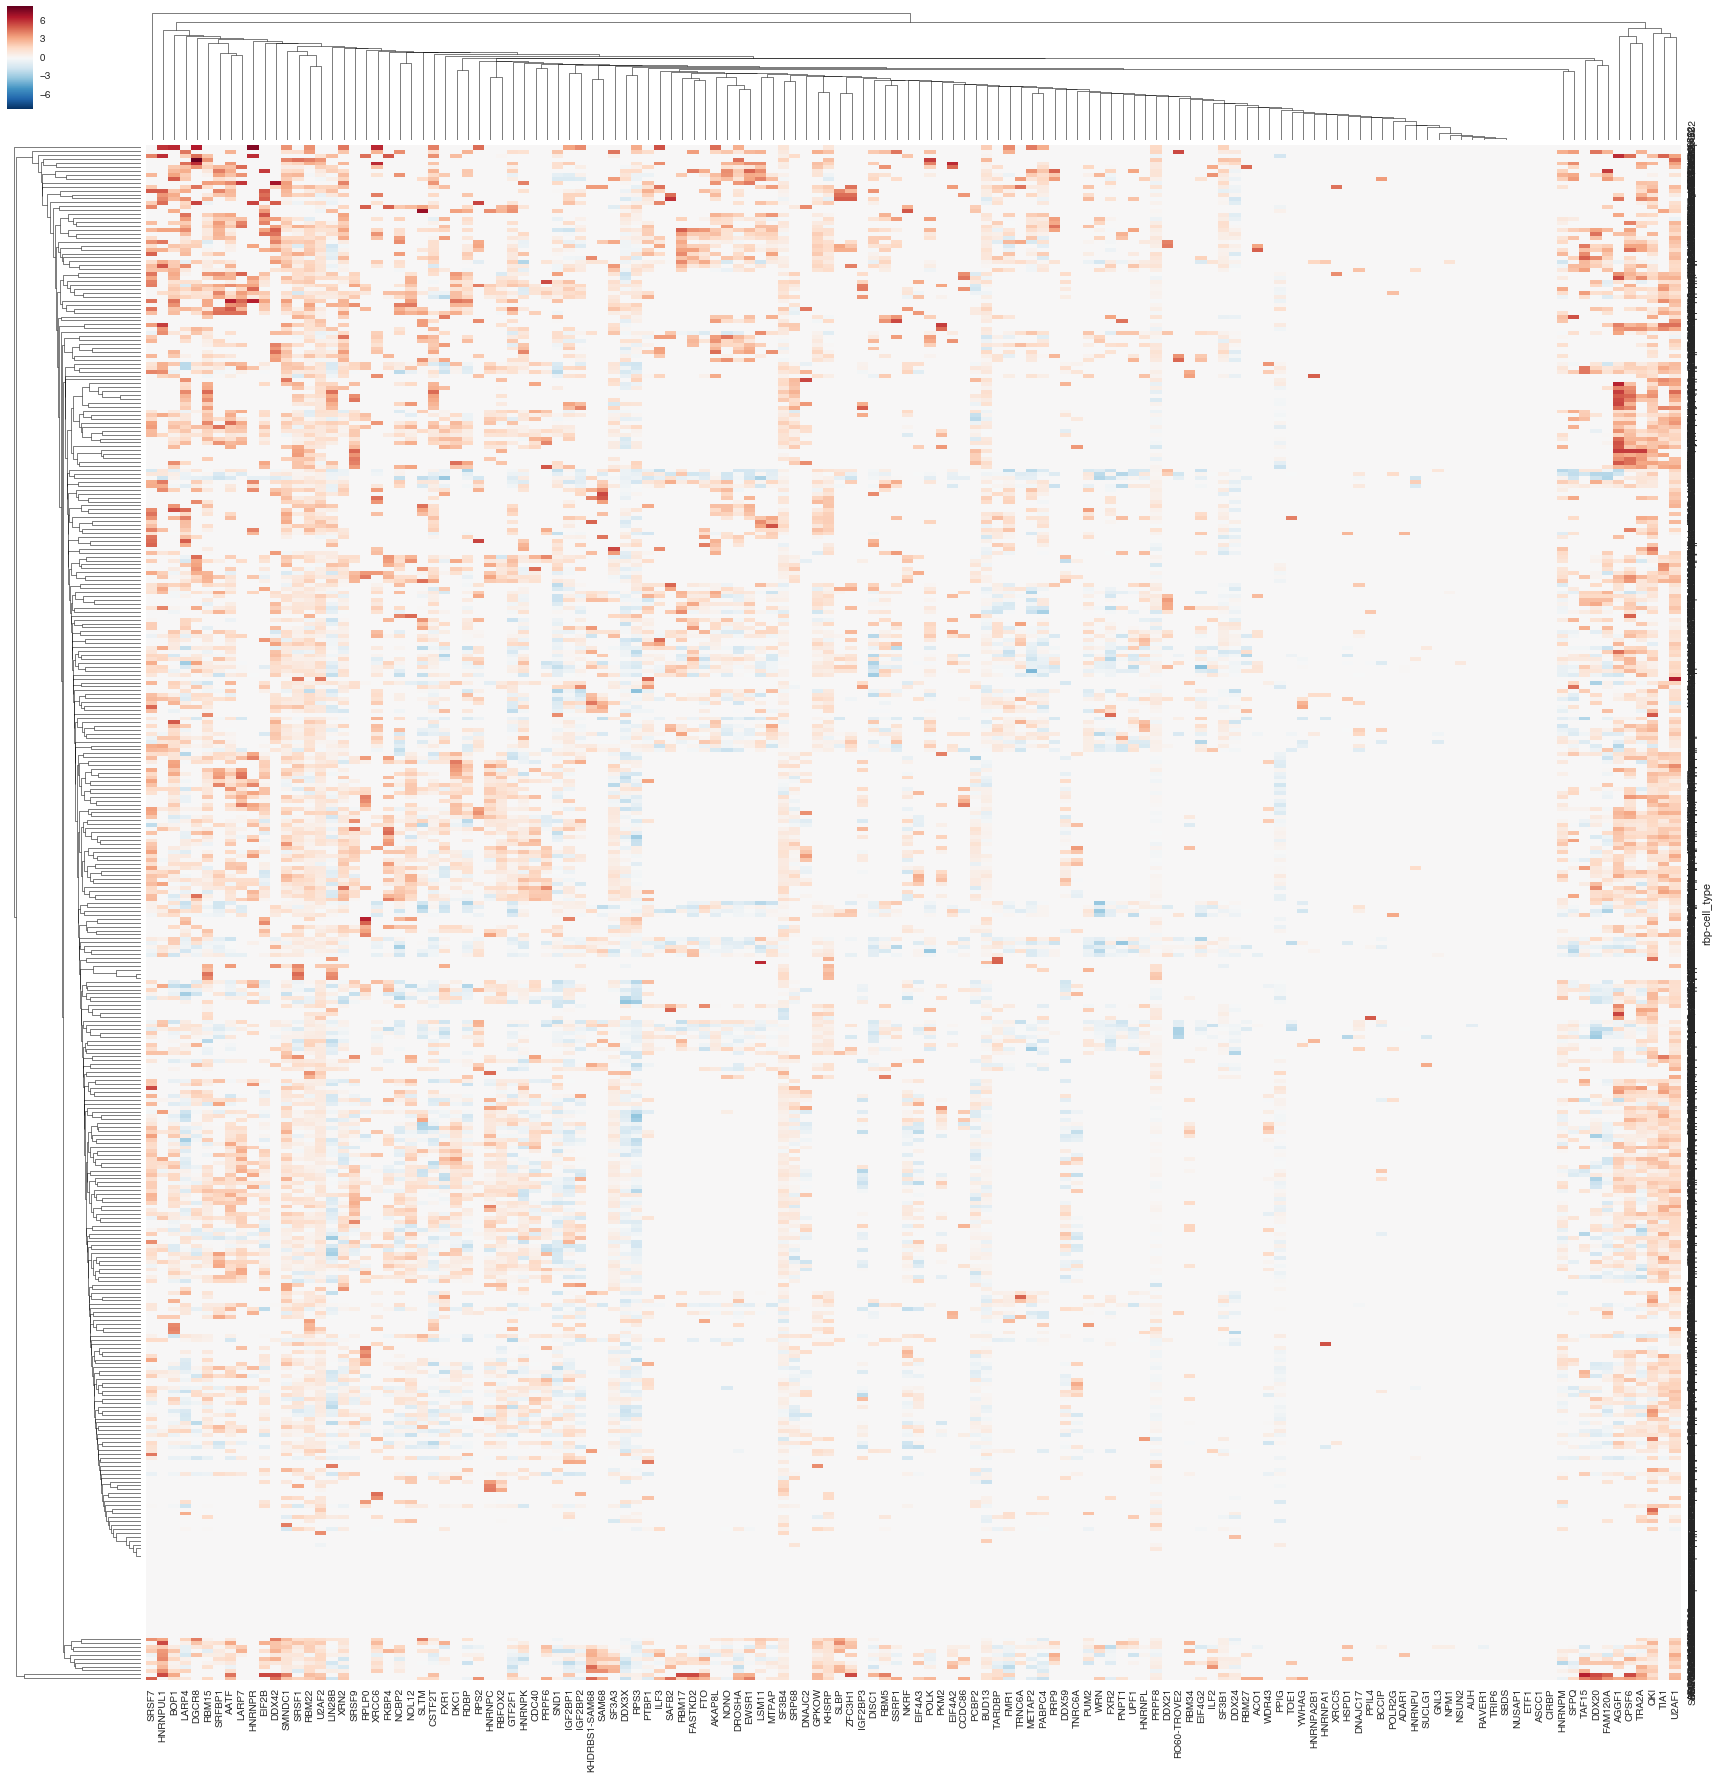

In [28]:
sns.clustermap(internal_fraction_enriched, figsize=(30,30))
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.pdf"))

This is cool, but doesn't tell me much yet, enriched and non-enriched genes in total, lets see if there are some super responsive RBPs

In [29]:
stress_conditions = ['CA', 'PQ', 'PQCA', 'hs', 'ars']

In [30]:
internal_fraction_enriched_k562 = internal_fraction_enriched.xs("K562", level=1)
internal_fraction_enriched_k562 = internal_fraction_enriched_k562[(internal_fraction_enriched_k562.sum() != 0).index]
internal_fraction_enriched_k562 = internal_fraction_enriched_k562.T.ix[internal_fraction_enriched_k562.sum() != 0].T

internal_fraction_enriched_hepg2 = internal_fraction_enriched.xs("HepG2", level=1)
internal_fraction_enriched_hepg2 = internal_fraction_enriched_hepg2[(internal_fraction_enriched_hepg2.sum() != 0).index]
internal_fraction_enriched_hepg2 = internal_fraction_enriched_hepg2.T.ix[internal_fraction_enriched_hepg2.sum() != 0].T


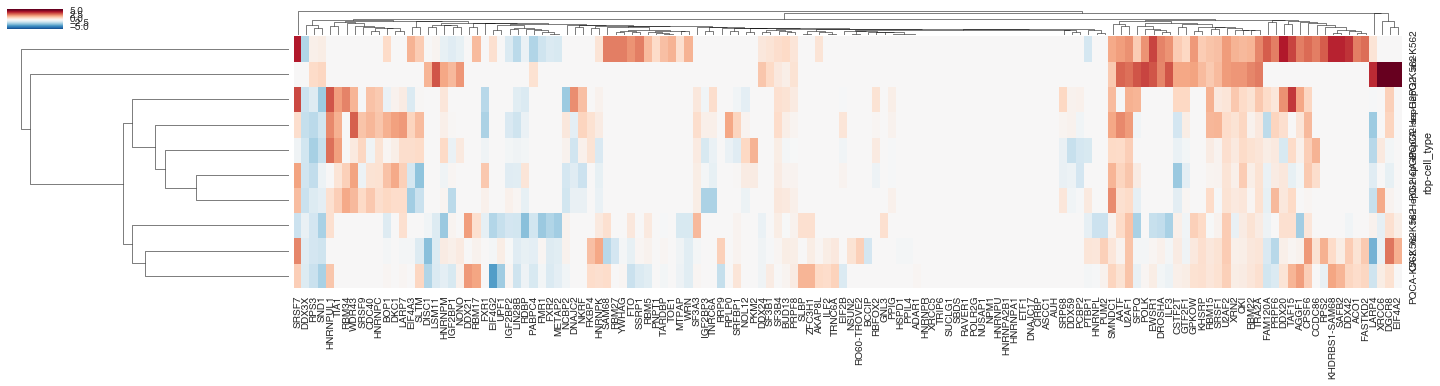

In [31]:
sns.clustermap(internal_fraction_enriched.ix[stress_conditions].fillna(0), figsize=(25,5))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched.pdf"))

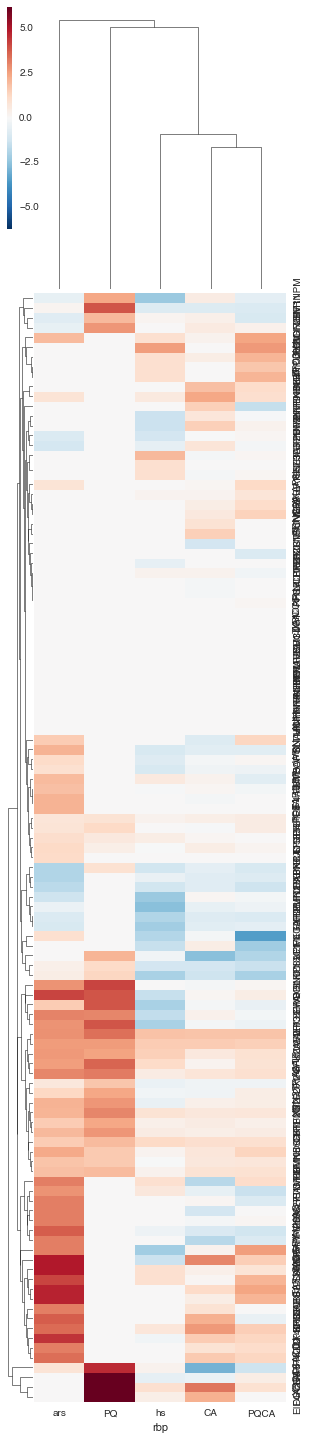

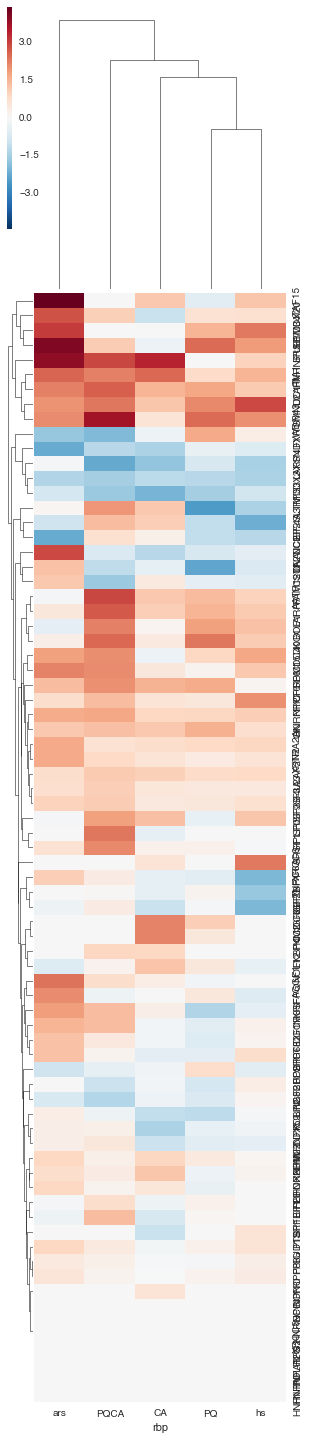

In [32]:
sns.clustermap(internal_fraction_enriched_k562.ix[stress_conditions].T.fillna(0), figsize=(5,25))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_k562.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_k562.pdf"))

sns.clustermap(internal_fraction_enriched_hepg2.ix[stress_conditions].T.fillna(0), figsize=(5,25))
fig = pyplot.gcf()

fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_hepg2.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_stress_enriched_hepg2.pdf"))

In [33]:
internal_fraction_enriched_filtered = internal_fraction_enriched.ix[[item in num_events.both.values and item in master_processing_table.both.values for item in internal_fraction_enriched.index.map(lambda x: "_".join(x))]]

NameError: name 'num_events' is not defined

In [ ]:
cg = sns.clustermap(internal_fraction_enriched_filtered, figsize=(30,30))
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_enriched.pdf"))

In [ ]:
num_events = pd.concat([all_sig_events.ix['SE'].groupby(level=1).count().FDR, 
          all_sig_events.ix['SE'].groupby(level=1).first().both], axis=1)
num_events = num_events[num_events.FDR > 100]

In [ ]:
foo = fraction_internal_bound['RBFOX2'].sort_values(ascending=False)[:10].index

In [ ]:
num_events[num_events.both.isin(foo)]

In [ ]:
overlapping_genes = internal_fraction_enriched.columns & internal_fraction_enriched.index.levels[0]

result = {}
for rbp in overlapping_genes:
    result[rbp] = internal_fraction_enriched[rbp].ix[rbp]
specific_enrichment = pd.concat(result)
specific_enrichment = pd.DataFrame(specific_enrichment)

In [ ]:
specific_enrichment['both'] = ["_".join(item) for item in specific_enrichment.index]

In [ ]:
specific_enrichment = specific_enrichment[specific_enrichment.both.isin(num_events.both)]

In [ ]:
with dataviz.Figure(os.path.join(heatmap_dir, "responsive_factors.svg"), figsize=(5, 15)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.barplot(x=specific_enrichment[0].sort_values(ascending=False), 
                y=specific_enrichment[0].sort_values(ascending=False).index.map(lambda x: " ".join(x)),
               ax=ax)
    sns.despine(ax=ax)

In [ ]:
with dataviz.Figure(os.path.join(heatmap_dir, "responsive_factors_top_10.svg"), figsize=(5, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.barplot(x=specific_enrichment[0].sort_values(ascending=False)[:10], 
                y=specific_enrichment[0].sort_values(ascending=False).index.map(lambda x: " ".join(x))[:10],
               ax=ax)
    ax.set_xlabel("Fraction enriched above background")
    ax.set_title("Top 10 Responsive RBPs")
    sns.despine(ax=ax)

QKI is responisvie, which is a good positive control, but other things not known to be splicing factors also are, thats kind of interesting

In [ ]:
sns.clustermap(fraction_internal_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "internal_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "internal_encode.pdf"))

In [ ]:
#fraction of events that are bound proximally by RBP
fraction_bound = (result_upstream > 0).groupby(level='both').sum().div(result_upstream.groupby(level='both').apply(len), axis=0)
sns.clustermap(fraction_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "upstream_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "upstream_encode.pdf"))

In [ ]:
#fraction of events that are bound proximally by RBP
fraction_bound = (result_downstream > 0).groupby(level='both').sum().div(result_downstream.groupby(level='both').apply(len), axis=0)
sns.clustermap(fraction_bound.fillna(0), figsize=(30,20))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "downstream_encode.svg"))
fig.savefig(os.path.join(heatmap_dir, "downstream_encode.pdf"))

# How about for Stressed exons?

In [ ]:
#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "SF3B4_included.svg"), figsize=(6, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(y=[item.split("_vs")[0] for item in fraction_bound['SF3B4'].index], 
                x=fraction_bound['SF3B4'].values * 100, ax=ax, orient="h")
    ax.set_xlabel("% of exons bound by SF3B4")
    ax.set_ylabel("Conidition")
    sns.despine(ax=ax)

In [ ]:
sns.clustermap((fraction_bound - fraction_bound.mean()) / fraction_bound.std(), figsize=(30,10))


In [ ]:
sns.clustermap((fraction_bound.sub(fraction_bound.mean(axis=1), axis=0)).div(fraction_bound.std(axis=1), axis=0), figsize=(30,10))

# Lets look at bound and regulated ranked as well

In [ ]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "internal_enriched_ranking.svg"), figsize=( num_cols * 5, num_rows * 25)) as fig:
    
    for x, stress_event in enumerate(fraction_explained_by_rnai.index):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=internal_fraction_enriched.ix[stress_event].sort_values(ascending=False), 
                    y=internal_fraction_enriched.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)